# Import, Cleaning and Exploring the data

In [772]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#basic externals
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import feather
from random import randint
from scipy import stats

#visual libs
import matplotlib.pyplot  as plt
import seaborn as sns

## testing statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

# Words processing models
from bs4 import BeautifulSoup        
import re #Regular exp
import nltk
from nltk.stem import SnowballStemmer, PorterStemmer, LancasterStemmer, WordNetLemmatizer

#local imports
from xm_functions import *

InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option(
    "display.float_format", lambda x: "%.3f" % x
)  # display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

### Import our dataset

Note : Our dataset is a manual extract of data from StackOverFlow, selecting title, post's body and tags, of 40K posts
<br> We selected a minimal length of 100 char to get enough data for classification
<br> We only selected questions without the answers for simplicty

In [773]:
file_path = 'QueryResults_40k.csv'
df = pd.read_csv(file_path)

In [774]:
df.describe()

,title,body,tags
count,43254,43254,43254
unique,43220,43253,30616
top,Column is invalid in the select list because i...,<p>Let's say I have an sql server table:</p>\n...,<java>
freq,5,2,581


# Having a look at a single post

### HTML parser Beautiful soup

In [775]:
post_id = 15#randint(0, df.shape[0]-1) 
post_title = df.loc[post_id].title
post_raw = df.loc[post_id].body
post_title
post_raw

'Finding and replacing a pair of characters in a string with another pair of characters in that string'

"<p>I'm new to Python, but want to figure out how to take a string and swap pairs of characters around. Let's say we have the string \n'HELLO__WORLD' and want to switch the HE in HELLO with __. So that the string now looks like '__LLOHEWORLD' How could that be done? Does it have anything to do with .pop and .append? Or perhaps if, elif, else functions could be used? Maybe to begin with, .index is needed to find the characters that the user specifies need to be swapped?</p>\n\n<p>I honestly have no idea really where to begin. </p>\n"

In [776]:
soup = BeautifulSoup(post_raw, "html.parser")
soup

<p>I'm new to Python, but want to figure out how to take a string and swap pairs of characters around. Let's say we have the string 
'HELLO__WORLD' and want to switch the HE in HELLO with __. So that the string now looks like '__LLOHEWORLD' How could that be done? Does it have anything to do with .pop and .append? Or perhaps if, elif, else functions could be used? Maybe to begin with, .index is needed to find the characters that the user specifies need to be swapped?</p>
<p>I honestly have no idea really where to begin. </p>

### Removing HTML tags

In [777]:
post_txt = soup.get_text()
post_txt

"I'm new to Python, but want to figure out how to take a string and swap pairs of characters around. Let's say we have the string \n'HELLO__WORLD' and want to switch the HE in HELLO with __. So that the string now looks like '__LLOHEWORLD' How could that be done? Does it have anything to do with .pop and .append? Or perhaps if, elif, else functions could be used? Maybe to begin with, .index is needed to find the characters that the user specifies need to be swapped?\nI honestly have no idea really where to begin. \n"

### Lower case

In [778]:
post_lower = post_txt.lower()
print("10 first Words")
post_lower[:100]

10 first Words


"i'm new to python, but want to figure out how to take a string and swap pairs of characters around. "

### Removing punctuation and such 

In [779]:
words_only  = re.sub("[^a-z+#]",
                      " ",
                      post_lower).split()
for i in words_only:
    print(i, end=" ")

i m new to python but want to figure out how to take a string and swap pairs of characters around let s say we have the string hello world and want to switch the he in hello with so that the string now looks like lloheworld how could that be done does it have anything to do with pop and append or perhaps if elif else functions could be used maybe to begin with index is needed to find the characters that the user specifies need to be swapped i honestly have no idea really where to begin 

## Counting words

In [780]:
df_words = pd.DataFrame(index = np.unique(words_only) )
df_words['count'] = 0

In [781]:
for word in words_only:
    df_words.loc[word, 'count'] += 1
df_words =df_words.sort_values('count', ascending  = False)

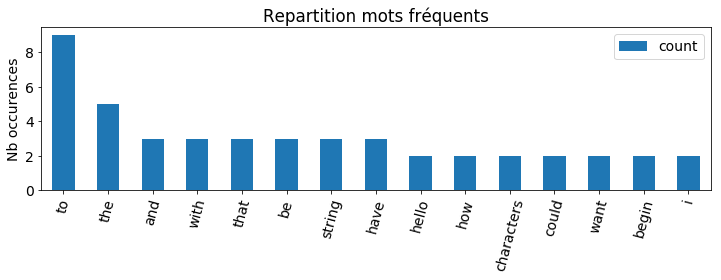

In [782]:
fig_size(12,3, 14)

ax = df_words.head(15).plot(kind='bar')
silent = ax.set_xticklabels(df_words.head(15).index, rotation=75)
legend(ax, 'Repartition mots fréquents', ' ', 'Nb occurences')

## Removing stop words

In [783]:
nltk.download('stopwords') 
from nltk.corpus import stopwords
df_words = df_words.loc[~df_words.index.isin(stopwords.words("english"))]

print (stopwords.words("english") )

[nltk_data] Downloading package stopwords to C:\Users\Maly-
[nltk_data]     Fenix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

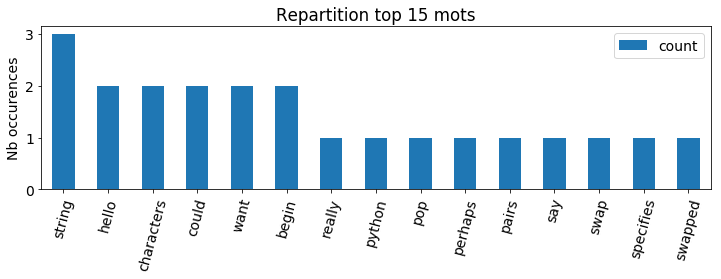

In [784]:
fig_size(12,3, 14)
df_words = df_words.loc[~df_words.index.isin(stopwords.words("english"))]

ax = df_words.head(15).plot(kind='bar')
silent = ax.set_xticklabels(df_words.head(15).index, rotation=75)

legend(ax, 'Repartition top 15 mots', ' ', 'Nb occurences')

In [785]:
print('Title: ', df.iloc[1].title)
transformed_str = np_str(df_words.index)
print('Tags: ',df.iloc[1].tags)

Title:  How to create channel on youtube to upload videos and is it possible to create channel programmatically?
Tags:  <ios><objective-c><video><youtube-data-api><youtube-channels>


##### We already have a pretty good indication of the content based on these words repartition

### Going further with Stemming or Lemmatizing 

In [786]:
def nltk_stem(algo, words):
    if isinstance(words, str):
        words = words.split()
    
    stem_words =[]
    algo_name = algo.__class__.__name__
    for word in words:
        if 'Stem' in algo_name:
            word = algo.stem(word) 
        elif 'Lem' in algo_name:
            word = algo.lemmatize(word) 
        else:
            print("Invalid algo")
            return
        #Add to array
        if word != "":
            stem_words.append(word)

    return np_str(stem_words)
    
        

In [787]:
#nltk.download('wordnet')

In [788]:
np_words = df_words.index
print(nltk_stem(SnowballStemmer('english'), np_words))
print(nltk_stem(LancasterStemmer(), np_words))
print(nltk_stem(PorterStemmer(), np_words))
print(nltk_stem(WordNetLemmatizer(), np_words))
np_words


string hello charact could want begin realli python pop perhap pair say swap specifi swap switch take use user new anyth append around done elif els figur find function honest need idea index let like lloheworld look mayb need world
string hello charact could want begin real python pop perhap pair say swap spec swap switch tak us us new anyth append around don el els fig find funct honest nee ide index let lik lloheworld look mayb nee world
string hello charact could want begin realli python pop perhap pair say swap specifi swap switch take use user new anyth append around done elif els figur find function honestli need idea index let like lloheworld look mayb need world
string hello character could want begin really python pop perhaps pair say swap specifies swapped switch take used user new anything append around done elif else figure find function honestly needed idea index let like lloheworld look maybe need world


Index(['string', 'hello', 'characters', 'could', 'want', 'begin', 'really',
       'python', 'pop', 'perhaps', 'pairs', 'say', 'swap', 'specifies',
       'swapped', 'switch', 'take', 'used', 'user', 'new', 'anything',
       'append', 'around', 'done', 'elif', 'else', 'figure', 'find',
       'functions', 'honestly', 'needed', 'idea', 'index', 'let', 'like',
       'lloheworld', 'looks', 'maybe', 'need', 'world'],
      dtype='object')

In [789]:
transform_text(post_raw)

'new python want figure take string swap pairs characters around let say string hello world want switch hello string looks like lloheworld could done anything pop append perhaps elif else functions could used maybe begin index needed find characters user specifies need swapped honestly idea really begin'

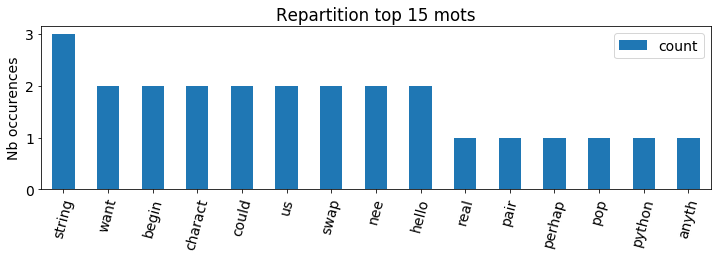

In [790]:
words_stem = nltk_stem(LancasterStemmer(), transform_text(post_raw)).split(' ')
df_words = pd.DataFrame(index = np.unique(words_stem))
df_words['count'] = 0
for word in words_stem:
    df_words.loc[word, 'count'] += 1
df_words =df_words.sort_values('count', ascending  = False)
fig_size(12,3, 14)
ax = df_words.head(15).plot(kind='bar')
silent = ax.set_xticklabels(df_words.head(15).index, rotation=75)

legend(ax, 'Repartition top 15 mots', ' ', 'Nb occurences')

## Applying transforms to our complete dataset

In [791]:
soup = BeautifulSoup(post_raw, "html.parser")
nltk.download('stopwords') 
from nltk.corpus import stopwords
stop_words = np.array(stopwords.words("english"))

def transform_text(txt):
    transformed_txt = BeautifulSoup(txt, "html.parser").get_text()
    transformed_txt = re.sub("[^a-zA-Z+#]", " ", transformed_txt)
    transformed_txt = np.array(transformed_txt.lower().split())
    transformed_txt= transformed_txt[~np.in1d(transformed_txt, stop_words, assume_unique=False)]
    return str(' '.join(map(str, transformed_txt)))

def transform_tags(tags):
    transformed_tags = tags[1:][:-1].replace('><', ' ')
    return transformed_tags

[nltk_data] Downloading package stopwords to C:\Users\Maly-
[nltk_data]     Fenix\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### All transforms before Stem / Lem

In [792]:
df_transformed =df.copy()
df_transformed['body']= df_transformed['body'].apply(transform_text)
df_transformed['title']= df_transformed['title'].apply(transform_text)
df_transformed['tags']= df_transformed['tags'].apply(transform_tags)

df_transformed['old_tags'] = df_transformed['tags']

### Stem / Lem
<br> Only keeping LancasterStemmer as it appears to be the best for our usecase

In [793]:
if True:
    df_transformed['body_LancasterStemmer'] = df_transformed['body'].apply(lambda x: nltk_stem(LancasterStemmer(), x))
    df_transformed['title_LancasterStemmer'] = df_transformed['title'].apply(lambda x: nltk_stem(LancasterStemmer(), x))
    df_transformed['old_body_LancasterStemmer'] = df_transformed['body_LancasterStemmer']
    df_transformed['old_title_LancasterStemmer'] = df_transformed['title_LancasterStemmer']
    
if False :
    df_transformed['body_SnowballStemmer'] = df_transformed['body'].apply(lambda x: nltk_stem(SnowballStemmer('english'), x))
    df_transformed['body_PorterStemmer'] = df_transformed['body'].apply(lambda x: nltk_stem(PorterStemmer(), x))
    df_transformed['body_WordNetLemmatizer'] = df_transformed['body'].apply(lambda x: nltk_stem(WordNetLemmatizer(), x))

    df_transformed['title_SnowballStemmer'] = df_transformed['title'].apply(lambda x: nltk_stem(SnowballStemmer('english'), x))
    df_transformed['title_PorterStemmer'] = df_transformed['title'].apply(lambda x: nltk_stem(PorterStemmer(), x))
    df_transformed['title_WordNetLemmatizer'] = df_transformed['title'].apply(lambda x: nltk_stem(WordNetLemmatizer(), x))

##### Display exemple

In [794]:
df['body'].head(3)
df_transformed.head(3)

0    <p>The other day I was trying to code a small ...
1    <p>I am using <a href="https://github.com/yout...
2    <p>Why   boolean containsAll(Collection &lt; ?...
Name: body, dtype: object

,title,body,tags,old_tags,body_LancasterStemmer,title_LancasterStemmer,old_body_LancasterStemmer,old_title_LancasterStemmer
0,certain situations require use bitwise operato...,day trying code small c++ programming using sd...,c++ event-handling sdl bitwise-operators boole...,c++ event-handling sdl bitwise-operators boole...,day try cod smal c++ program us sdl multimed l...,certain situ requir us bitw op instead log eq op,day try cod smal c++ program us sdl multimed l...,certain situ requir us bitw op instead log eq op
1,create channel youtube upload videos possible ...,using https github com youtube yt direct lite ...,ios objective-c video youtube-data-api youtube...,ios objective-c video youtube-data-api youtube...,us https github com youtub yt direct lit io sa...,cre channel youtub upload video poss cre chann...,us https github com youtub yt direct lit io sa...,cre channel youtub upload video poss cre chann...
2,design decision boolean containsall collection...,boolean containsall collection c method collec...,java generics wildcard,java generics wildcard,bool containsal collect c method collect frame...,design decid bool containsal collect c vs bool...,bool containsal collect c method collect frame...,design decid bool containsal collect c vs bool...


## Removing rare words

 We'll remove rare words which appear less than 1 / 1000 posts <br> This can be done more easily with TFIDF or countvectorizer params, but this allows us to have a better vision of what will be ignored

In [795]:
df_transformed['body_LancasterStemmer'] = df_transformed['old_body_LancasterStemmer']
df_transformed['title_LancasterStemmer'] = df_transformed['old_title_LancasterStemmer']
lancaster_full_txt =''
my_set = 500
for i in range(0, df_transformed.shape[0]+1, my_set):
    lancaster_full_txt += np_str(df_transformed.loc[i:i+my_set-1, 'body_LancasterStemmer'].values)+' '
    lancaster_full_txt += np_str(df_transformed.loc[i:i+my_set-1, 'title_LancasterStemmer'].values)+' '

In [796]:
print(len(lancaster_full_txt.split(' ')), 'words in total')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
countvector = CountVectorizer(lowercase=False, token_pattern = '[^\s]+')
# Apply fit_transform 
csrm = countvector.fit_transform([lancaster_full_txt])

features = pd.Series([word for word in countvector.get_feature_names()])
df_complete_words= pd.DataFrame(csrm.toarray(), index=['count'],  columns=features.values).T

print(df_complete_words.shape[0], 'unique words')

4667009 words in total
114935 unique words


In [798]:
df_complete_words.quantile(0.8)[0]
#inverse of quantile
stats.percentileofscore(df_complete_words['count'],43)
df_complete_words['Group'] = df_complete_words['count'].apply(lambda x: 1 if x>43 else 0)

5.0

95.87114455996868

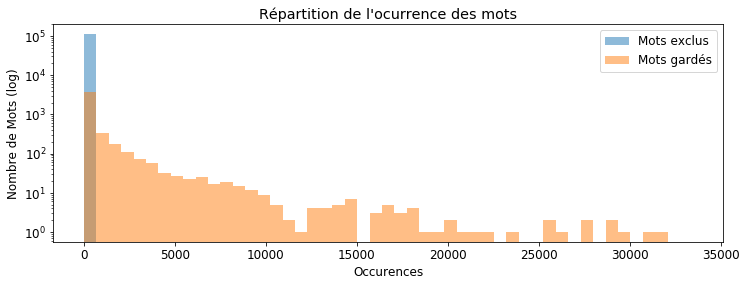

In [723]:
fig_size(12,4, 12)
df_current = df_complete_words
nb_groups=2
column_names = ['Mots exclus','Mots gardés']
df_plot=pd.DataFrame(np.zeros((df_current.shape[0],nb_groups)), index = df_current.index,  columns=column_names)
for Group in range (0,nb_groups):
    df_group = df_current[df_current['Group'] == Group]['count'].sort_values().round(0).reset_index().groupby('index').agg('sum' )
    df_plot.loc[df_group.index.values,[column_names[Group]]] = df_group.values
    
df_plot.plot.hist( bins =np.linspace(1, df_plot.quantile(0.99999).max(),50) ,histtype='bar',  stacked=False, alpha =0.5)
legend(plt, 'Répartition de l\'ocurrence des mots', 'Occurences', 'Nombre de Mots (log)' )
plt.yscale('log')
plt.show()

In [806]:
df_complete_words.sort_values('count', ascending=False).head(100).index.values

array(['us', 'class', 'get', 'fil', 'er', 'dat', 'valu', 'cod', 'string',
       'id', 'new', 'nam', 'funct', 'int', 'return', 'lik', 'work',
       'publ', 'typ', '+', 'want', 'jav', 'on', 'list', 'c', 'serv',
       'object', 'ap', 'set', 'x', 'com', 'method', 'cre', 'stat',
       'would', 'ad', 'array', 'android', 'try', 'b', 'run', 'way', 'nee',
       'tabl', 'system', 'cal', 'apply', 'text', 'div', 'numb', 'tim',
       'select', 'e', 'lin', 'follow', 'act', 'test', 'form', 'mak',
       'problem', 'input', 'var', 'diff', 'chang', 'void', 'first',
       'exampl', 'pag', 'ev', 'result', 'n', 'op', 'el', 'know', 'vary',
       'column', 'view', 'help', 'row', 'find', 'button', 'nul', 'im',
       'bas', 'project', 'item', 'vert', 'mod', 'quest', 'tru', 'html',
       'program', 'end', 'two', 'main', 'php', 'http', 'writ', 'key',
       'also'], dtype=object)

In [725]:
def filter_words(words, words_to_keep):
    if isinstance(words, str):
        words = np.array(words.split(' '))
    if isinstance(words_to_keep, str):
        words_to_keep = np.array(words_to_keep.split(' '))
        
    words_kept = np_str(words[np.in1d( words,  words_to_keep, assume_unique=False)])
    return words_kept

In [749]:
df_high_occ_words = df_complete_words[df_complete_words['Group'] == 1]
print( 100*df_high_occ_words.shape[0] / df_complete_words.shape[0] , 'of unique words remaining')
print(df_high_occ_words.shape[0]  ,'out of', df_complete_words.shape[0])
print( 100*df_high_occ_words['count'].sum() / df_complete_words['count'].sum() , 'of total words remaining')
print(df_high_occ_words['count'].sum()  ,'out of', df_complete_words['count'].sum())


4.096228302953843 of unique words remaining
4708 out of 114935
91.16120320445408 of total words remaining
4254497 out of 4667004


In [750]:
pre_transform = '_LancasterStemmer'
list_high_occ_words =  list(df_high_occ_words.index)
df_transformed['body'+pre_transform] = df_transformed['old_body'+pre_transform].apply(lambda x: filter_words(x, list_high_occ_words))
df_transformed['title'+pre_transform] = df_transformed['old_title'+pre_transform].apply(lambda x: filter_words(x, list_high_occ_words))

## Removing rare tags

In [799]:
df_transformed['tags'] = df_transformed['old_tags']
tags_full_txt =''
my_set = 500
for i in range(0, df_transformed.shape[0]+1, my_set):
    tags_full_txt += np_str(df_transformed.loc[i:i+my_set-1, 'tags'].values)+' '

In [800]:
print(len(tags_full_txt.split(' ')), 'tags in total')

# Apply fit_transform 
countvector = CountVectorizer(lowercase=False, token_pattern = '[^\s]+')
csrm = countvector.fit_transform([tags_full_txt])

features = pd.Series([tag for tag in countvector.get_feature_names()])
df_complete_tags= pd.DataFrame(csrm.toarray(), index=['count'],  columns=features.values).T

print(df_complete_tags.shape[0], 'unique tags')

df_complete_tags.quantile(0.8)[0]
#inverse of quantile
stats.percentileofscore(df_complete_tags['count'],43)
df_complete_tags['Group'] = df_complete_tags['count'].apply(lambda x: 1 if x>43 else 0)

133470 tags in total
10982 unique tags


6.0

96.51247495902386

In [801]:
df_complete_tags[df_complete_tags['Group'] ==1].quantile(0.9)

count   383.800
Group     1.000
Name: 0.9, dtype: float64

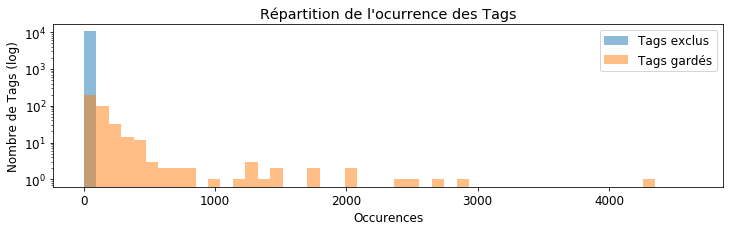

In [802]:
fig_size(12,3, 12)
df_current = df_complete_tags
nb_groups=2
column_names = ['Tags exclus','Tags gardés']
df_plot=pd.DataFrame(np.zeros((df_current.shape[0],nb_groups)), index = df_current.index,  columns=column_names)
for Group in range (0,nb_groups):
    df_group = df_current[df_current['Group'] == Group]['count'].sort_values().round(0).reset_index().groupby('index').agg('sum' )
    df_plot.loc[df_group.index.values,[column_names[Group]]] = df_group.values
    
df_plot.plot.hist( bins =np.linspace(1, df_plot.quantile(0.9999).max(),50) ,histtype='bar',  stacked=False, alpha =0.5)
legend(plt, 'Répartition de l\'ocurrence des Tags', 'Occurences', 'Nombre de Tags (log)' )
plt.yscale('log')
plt.show()

In [731]:
df_complete_tags.sort_values('count', ascending=False).head(10).T

df_high_occ_tags = df_complete_tags[df_complete_tags['Group'] == 1]
print( 100*df_high_occ_tags.shape[0] / df_complete_tags.shape[0] , 'of unique tags remaining')
print(df_high_occ_tags.shape[0]  ,'out of', df_complete_tags.shape[0])
print( 100*df_high_occ_tags['count'].sum() / df_complete_tags['count'].sum() , 'of total tags remaining')
print(df_high_occ_tags['count'].sum()  ,'out of', df_complete_tags['count'].sum())


,java,c#,javascript,python,android,php,c++,jquery,html,ios
count,5582,4670,4330,2841,2709,2500,2400,2076,2015,1776
Group,1,1,1,1,1,1,1,1,1,1


3.4511018029502822 of unique tags remaining
379 out of 10982
68.324479841761 of total tags remaining
91192 out of 133469


In [744]:
list_high_occ_tags =  list(df_high_occ_tags.index)+['null']
df_transformed['tags'] = df_transformed['old_tags'].apply(lambda x: filter_words(x, list_high_occ_tags))

In [745]:
list_high_occ_tags

['.net',
 '.net-4.0',
 'abstract-class',
 'actionscript-3',
 'active-directory',
 'activerecord',
 'ado.net',
 'ajax',
 'algorithm',
 'amazon-s3',
 'amazon-web-services',
 'android',
 'android-activity',
 'android-fragments',
 'android-gradle',
 'android-intent',
 'android-layout',
 'android-recyclerview',
 'android-studio',
 'angular',
 'angularjs',
 'ant',
 'apache',
 'apache-spark',
 'api',
 'architecture',
 'arguments',
 'arraylist',
 'arrays',
 'asp.net',
 'asp.net-core',
 'asp.net-mvc',
 'asp.net-mvc-3',
 'asp.net-mvc-4',
 'asp.net-web-api',
 'assembly',
 'asynchronous',
 'authentication',
 'automation',
 'awk',
 'azure',
 'bash',
 'batch-file',
 'boost',
 'browser',
 'build',
 'button',
 'c',
 'c#',
 'c#-4.0',
 'c++',
 'c++11',
 'caching',
 'cakephp',
 'casting',
 'checkbox',
 'class',
 'clojure',
 'cmd',
 'cocoa',
 'cocoa-touch',
 'codeigniter',
 'coding-style',
 'coldfusion',
 'collections',
 'command-line',
 'compilation',
 'compiler-construction',
 'compiler-errors',
 'concu

In [746]:
df_transformed[['old_tags', 'tags']].sample(100)

,old_tags,tags
41851,sql-server sql-server-2008 tsql,sql-server sql-server-2008 tsql
10164,javascript html5,javascript html5
9652,c# visual-studio-2015,c# visual-studio-2015
41072,c# wpf data-binding,c# wpf data-binding
39405,windows-phone windows-phone-8.1,
42066,php javascript html,php javascript html
6501,javascript variables variable-assignment,javascript variables
4327,windows-8 windows-runtime nuget portable-class...,nuget
25836,sql-server,sql-server
40241,regex bash awk sed,regex bash awk sed


## Exporting transformed data on feather file

In [747]:
df_transformed.to_feather('df_transformed_stackoverflow_posts.feather')